In [511]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from flask import Flask, render_template
from sklearn.datasets import make_blobs 
from mpl_toolkits.mplot3d import Axes3D
import random
from itertools import groupby
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import itertools
from functools import reduce
from itertools import product
from itertools import combinations
import scipy.stats as stats
import pickle
import os
import time




In [334]:
def choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie):
    
    dict_composition_features = dict() # contient le nombre de catégorie pour chaque feature 
    columns = []
    nombre_individu_distinct = 1
    for i in range(nb_feature):
        feature = 'feature'+str(i)
        dict_composition_features[feature] = random.randint(nb_min_categorie, nb_max_categorie)
        columns.append(feature)
        nombre_individu_distinct = nombre_individu_distinct * dict_composition_features[feature]

    return dict_composition_features , nombre_individu_distinct

def generer_des_groupes(dict_composition_features,nb_groupes):
    groupes = []
    for i in range(nb_groupes):
        groupe_i = []
        for feature in dict_composition_features:
            max = dict_composition_features[feature]
            nb = random.randint(1,max)
            groupe_i.append(random.sample(range(1,max+1), nb))
        groupes.append(groupe_i)
    return groupes

def nb_possibilite(groupes):
    return [reduce((lambda x, y: x * y), list(map((lambda x: len(x) ), g))) for g in groupes]

def distance(x,y):
    set1 = set(x)
    set2 = set(y)
    similarity = len(set1.intersection(set2)) / len(set1.union(set2))
    return 1 - similarity

def distance_groupes(x,y):
    l = [distance(x[i],y[i]) for i in range(len(x)) ]
    return sum(l) / len(l)

def distance_moyenne_entre_paires_groupes(groupes):
    cmpt = 0
    summ = 0
    list_dist = []
    for pair in itertools.combinations(list(range(len(groupes))), 2):
        cmpt = cmpt + 1
        tmp = distance_groupes(groupes[pair[0]],groupes[pair[1]])
        summ = summ + tmp
        list_dist.append((pair[0],pair[1],tmp))
    return summ/cmpt , list_dist


def appartenance_groupe(individu,groupes):
    ind=0
    indices = []
    for g in groupes:
        test = True
        for i in range(len(g)):
            if individu[i] not in g[i]:
                test = False
                break
        if test == True:
            indices.append(ind)
        ind=ind+1
    return indices


def nombre_individu_par_groupes(df,groupes):
    cmpt_gr = [0] * len(groupes)
    intersection_cmpt = [0] * len(groupes)
    sans = 0
    for i in range(len(df)):
        individu = list(df.iloc[i])
        L = appartenance_groupe(individu,groupes)
        if L == [] :
            sans = sans + 1
        else :
            intersection_cmpt[len(L)-1] = intersection_cmpt[len(L)-1] + 1
        for l in L :
            cmpt_gr[l] = cmpt_gr[l] + 1
    return cmpt_gr , intersection_cmpt, sans

def predict_nombre_individu_par_groupes_sum(taille_df,nombre_individu_distinct,nb_possibilite):
    tmp = nb_possibilite / nombre_individu_distinct
    return tmp * taille_df


def choisir_alea(groupe,nb):
    max_unique_combi = nb_possibilite([groupe])[0]
    num_combos = min (max_unique_combi , nb)
    combos = []
    while len(combos) < num_combos :
        combo = []
        for g in groupe :
            combo.append(random.sample(g, 1)[0])
        if combo not in combos :
            combos.append(combo)
    return combos


def generer_all_unique_possi_df(groupe, id_groupe,taille):
    columns = ['feature'+str(f) for f in range(len(groupe))]
    #print('ok1')
    combinations  = choisir_alea(groupe,taille)
    #print('ok2')
    df = pd.DataFrame(combinations,columns=columns)
    df = df.assign(id_groupe = id_groupe)
    return df

def generer_all_unique_possi_df_for_groups(groupes,list_id,taille) :
    columns = ['feature'+str(f) for f in range(len(groupes[0]))]
    columns.append('id_groupe')
    df = pd.DataFrame(columns=columns)
    for i in list_id :
        tmp_df = generer_all_unique_possi_df(groupes[i], i,taille)
        df = pd.concat([df, tmp_df], axis=0)
    return df.reset_index().drop('index', axis=1)

def reblance_df(df,nb_groupes):
    # Et Avoir aussi au moins 10 rows, ca sera notre base pour entrainer le modèle 
    max_individu_grp = max(df['id_groupe'].value_counts())
    for id in range(nb_groupes) :
        nb_individu = (df['id_groupe']==id).sum()
        if(nb_individu<max_individu_grp):
            duppli =(max_individu_grp // nb_individu) - 1
            duppli_rand = max_individu_grp % nb_individu
            tmp_df = df[df['id_groupe']==id]
            if duppli > 0 :
                tmp_df = pd.concat([tmp_df] * duppli, ignore_index=True)
                tmp_df = pd.concat([tmp_df,tmp_df.sample(n=duppli_rand)], ignore_index=True)
            if duppli == 0:
                tmp_df = tmp_df.sample(n=duppli_rand)
            df = pd.concat([df,tmp_df], ignore_index=True)
    return df


def shape_train_df(df,nb_rows,len_group,ratio_balanced,dist='uniform'):
    distributions = {"expon": stats.expon(loc=0, scale=1),"poisson": stats.poisson(mu=1),"gamma": stats.gamma(a=1, loc=0, scale=1),"pareto": stats.pareto(b=1),"lognorm": stats.lognorm(s=1, loc=0, scale=1),"uniform": stats.uniform(loc=0, scale=1)}
    # Le ratio commun entre 0 et 1 est départagé equitablement entre les différents groupes puis le 1 - ratio_commun est departagé inequitablement pour le desequilibre
    if (ratio_balanced<0 or ratio_balanced>1 ):
        print("Ratio not between 0 and 1")
        return None 
    base_ratios = [ratio_balanced/len_group for i in range(len_group)]
    unblanced_ratio = 1 - ratio_balanced
    dist_ratios = distributions[dist].rvs(size=len_group)
    dist_ratios = dist_ratios / sum(dist_ratios)
    dist_ratios = sorted(dist_ratios, reverse=True)
    dist_ratios = [r * unblanced_ratio for r in dist_ratios]
    wanted_groups_number = [int((x + y)*nb_rows) for x, y in zip(base_ratios, dist_ratios)] 
    random.shuffle(wanted_groups_number) 
    actual_groups_number = df['id_groupe'].value_counts()[0] 

    final_df = pd.DataFrame(columns=df.columns)

    for id_g  in range(len_group):
        wanted = wanted_groups_number[id_g]
        tmp_df = df[df['id_groupe']==id_g]
        if(wanted <= actual_groups_number):
            final_df = pd.concat([final_df,tmp_df.sample(n=wanted)],ignore_index=True)
        else :
            duppli =(wanted // actual_groups_number)
            duppli_rand = wanted % actual_groups_number
            tmp_df = pd.concat([tmp_df] * duppli, ignore_index=True)
            tmp_df = pd.concat([tmp_df,tmp_df.sample(n=duppli_rand)], ignore_index=True)
            final_df = pd.concat([final_df,tmp_df], ignore_index=True)
    
    return final_df 


def compter_diversite(df):
    num_groupes = list(df['id_groupe'].unique())
    disp = []
    for n in num_groupes :
        tmp_df = df[df['id_groupe']==n]
        tmp_df = tmp_df[tmp_df.columns[:-1]]
        prop = tmp_df.duplicated().sum() * 100 / len(tmp_df)
        disp.append((n,str(int(prop))+'% duplique',len(tmp_df) ) )
    return disp

In [434]:
def reshape_dictionnaire_data(data):
    f=pd.DataFrame(data['other_info']['composition des features'],index=['nb of class'])
    ##################################################################################################
    ind = ['compo groupe '+str(i) for i in range(len(data['other_info']['composition des groupes']))]
    df = pd.DataFrame(data['other_info']['composition des groupes'],columns=f.columns,index =ind )
    ##################################################################################################
    general = pd.concat([f,df])
    general['nb disctint person possible'] = ['-']+data['other_info']['nombre possibilite individu dans les groupes']
    general['diversite des groupes'] = ['-']+data['other_info']['diversite des groupes']
    data['info_df'] = general
    tmp = data['other_info']
    del data['other_info']
    del tmp['composition des features']
    del tmp['composition des groupes']
    del tmp['nombre possibilite individu dans les groupes']
    del tmp['diversite des groupes'] 
    data['Other Information']= tmp
    return data

def ordonner(Datas):
    return sorted(Datas, key=lambda x: int(x[1][-2:])) # ATTENTION A CHANGER CAR MARCHE SI GROUPES SUR 2 CHIFFRE SINON ERREUR !!!!!

def generete_data(nombre_feature,nombre_div_cat_min,nombre_div_cat_max,nombre_groupe,nb_lignes,ratio_de_disparite_inter_group,dist):
    dict_info_data = {}
    ############################
    dict_info_data['nombre de ligne']=nb_lignes
    dict_info_data['ratio_de_disparite_inter_group'] = ratio_de_disparite_inter_group
    dict_info_data['Loi de distribution de dispartibe'] = dist
    ############################
    dict_composition_features , nombre_individu_distinct = choix_compo_features(nombre_feature,nombre_div_cat_min,nombre_div_cat_max)
    dict_info_data['nb de col avec one hot'] = sum(dict_composition_features.values())
    dict_info_data['indiviud distinct'] = nombre_individu_distinct
    dict_info_data['composition des features'] = dict_composition_features
    #print(nombre_individu_distinct)
    #print(sum(dict_composition_features.values()))
    ############################
    groupes = generer_des_groupes(dict_composition_features,nombre_groupe)
    dict_info_data['composition des groupes'] = groupes
    moy , list_dist = distance_moyenne_entre_paires_groupes(groupes)
    nb_possi = nb_possibilite(groupes)
    dict_info_data['distance moyenne entre paires groupes'] = moy
    dict_info_data['nombre possibilite individu dans les groupes'] = nb_possi
    dict_info_data['distance entre paires groupes '] = list_dist
    ############################
    test = True
    while test :
        df = generer_all_unique_possi_df_for_groups(groupes,list(range(len(groupes))),20000) # ->>>>> A VARIER SI BESOIN SI BCP BCP DE LIGNES
        df = df.sample(frac=1).reset_index(drop=True)
        df.drop_duplicates(subset=list(df.columns[:-1]), keep='last', inplace=True) # <----------- Enleve deux individu pareils pour ne pas etre dans 2 groupes differents
        # Car donne de mauvais resultats pour les algos voir si cas possible dans la realite , se produit quand très peu de nb individu discints 
        if len(df['id_groupe'].unique()) == len(groupes) : # ca veut dire un groupe inclu dans un autre et on veut pas ca , si egal ok
            test = False
            # Alors ok on peut passer étape suivante
    ############################
    df = reblance_df(df,len(groupes))
    final_df = shape_train_df(df,nb_lignes,len(groupes),ratio_de_disparite_inter_group,dist)
    dict_info_data['diversite des groupes'] = compter_diversite(final_df)
    ############################
    cmpt_gr , intersection_cmpt, sans= nombre_individu_par_groupes(final_df,groupes)
    dict_info_data['nb individu ds chaque groupes'] = cmpt_gr
    dict_info_data['nb de cross'] = intersection_cmpt
    ############################
    df_encoded = pd.get_dummies(final_df,columns=list(final_df.columns)[:-1]).astype(int)
    df_encoded['cluster']= df_encoded['id_groupe']
    df_encoded=df_encoded.drop('id_groupe',axis=1)
    df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)
    dict_info_data['nombre d individu duplique en % dans final df'] =(df_encoded.duplicated().sum())*100/len(df_encoded)
        
    if  (df_encoded.shape[1] != sum(dict_composition_features.values()) + 1):
        print('Il y aura probleme de noramlisation dans méthode 2 dans dict_composition_features')

    return final_df , df_encoded , dict_info_data
    


In [435]:
"""nb_de_colonne = [5,10,15]
nb_categorie_feature =[5,12]
nombre_groupe = [10,30,50] 
avancement = len(nb_de_colonne)*len(nb_categorie_feature)*len(nombre_groupe)
chemin = '/Users/soufiane/Documents/GitHub/universe/Data_Rl_Simulation/' # ATTENTION A CONFIGURER SELON ENVIRONEMENT

i=1
for c in nb_de_colonne:
    for f in nb_categorie_feature :
        for g in nombre_groupe:
            final_df , df_encoded , dict_info_data = generete_data(c,2,f,g,30000,1,'uniform')
            fichier_name = chemin+'DataSimuRl_c_'+str(c)+'_f_'+str(f)+'_g_'+str(g)
            data = {'nb_de_colonne':c,'nb_categorie_max_par_colonne':f,'nombre_groupe':g,'df': final_df, 'df_encoded':df_encoded,'other_info': dict_info_data}
            with open(fichier_name, 'wb') as fichier:
                pickle.dump(data, fichier)
            print(fichier_name,' | DONE ',' | Avancement : ',i,' sur ',avancement)
            i=i+1"""



"nb_de_colonne = [5,10,15]\nnb_categorie_feature =[5,12]\nnombre_groupe = [10,30,50] \navancement = len(nb_de_colonne)*len(nb_categorie_feature)*len(nombre_groupe)\nchemin = '/Users/soufiane/Documents/GitHub/universe/Data_Rl_Simulation/' # ATTENTION A CONFIGURER SELON ENVIRONEMENT\n\ni=1\nfor c in nb_de_colonne:\n    for f in nb_categorie_feature :\n        for g in nombre_groupe:\n            final_df , df_encoded , dict_info_data = generete_data(c,2,f,g,30000,1,'uniform')\n            fichier_name = chemin+'DataSimuRl_c_'+str(c)+'_f_'+str(f)+'_g_'+str(g)\n            data = {'nb_de_colonne':c,'nb_categorie_max_par_colonne':f,'nombre_groupe':g,'df': final_df, 'df_encoded':df_encoded,'other_info': dict_info_data}\n            with open(fichier_name, 'wb') as fichier:\n                pickle.dump(data, fichier)\n            print(fichier_name,' | DONE ',' | Avancement : ',i,' sur ',avancement)\n            i=i+1"

In [470]:
chemin = '/Users/soufiane/Documents/GitHub/universe/Data_Rl_Simulation'
fichiers = os.listdir(chemin)
Datas = []
for nom_fichier in fichiers:
    with open(chemin+'/'+nom_fichier, 'rb') as f:
        data = pickle.load(f)
        data = reshape_dictionnaire_data(data)
        print(nom_fichier, " , ",data['Other Information']['indiviud distinct'], " , ",data['Other Information']['nb de col avec one hot']," , ",data['Other Information']['nb de cross'][:3])
        #Datas.append(data)
        Datas.append((data,nom_fichier))
Datas = ordonner(Datas)

    

DataSimuRl_c_15_f_12_g_10  ,  399168000000  ,  102  ,  [29800, 200, 0]
DataSimuRl_c_5_f_5_g_30  ,  1500  ,  22  ,  [4301, 7416, 7084]
DataSimuRl_c_10_f_12_g_30  ,  33454080  ,  69  ,  [24453, 5043, 477]
DataSimuRl_c_5_f_12_g_30  ,  11880  ,  37  ,  [5519, 7874, 6653]
DataSimuRl_c_15_f_5_g_50  ,  9953280  ,  46  ,  [27784, 2137, 74]
DataSimuRl_c_15_f_5_g_10  ,  129600000  ,  55  ,  [29858, 142, 0]
DataSimuRl_c_15_f_12_g_50  ,  3585859200000  ,  112  ,  [29546, 452, 2]
DataSimuRl_c_10_f_5_g_30  ,  108000  ,  34  ,  [23595, 5505, 845]
DataSimuRl_c_10_f_12_g_50  ,  1995840  ,  53  ,  [17784, 9439, 2420]
DataSimuRl_c_5_f_5_g_50  ,  300  ,  17  ,  [0, 39, 77]
DataSimuRl_c_10_f_5_g_10  ,  288000  ,  37  ,  [29261, 739, 0]
DataSimuRl_c_15_f_5_g_30  ,  41472000  ,  51  ,  [29036, 964, 0]
DataSimuRl_c_5_f_12_g_50  ,  2400  ,  29  ,  [1036, 3519, 5406]
DataSimuRl_c_5_f_12_g_10  ,  3240  ,  29  ,  [23156, 5822, 924]
DataSimuRl_c_10_f_5_g_50  ,  115200  ,  34  ,  [17838, 8857, 2890]
DataSimuRl_c_5_

In [463]:
class linucb_disjoint_arm():

        # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha,version):

        #Version of algorihtm
        self.version = version

        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])

        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
        self.alpha_list = []
                
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
            
        self.A_inv = np.linalg.inv(self.A) 

        
        self.theta = np.dot(self.A_inv, self.b) # each point of covariate estime une importance globale qu'accorde une arm à chaque feature
        
        x = x_array.reshape([-1,1])
       
        theta_x = np.dot(self.theta.T,x)
        incert_x =  self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv,x)))

        p = theta_x +   incert_x # !!TESTER AVEC DEUX X DIFFERENTS CE QUE CA DONNE!!
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A.copy())
        self.A_incertitude_list.append(self.A.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(self.theta.copy())
        self.alpha_list.append(self.alpha)
        # -----------------
        return p , theta_x , incert_x
    
    
    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1,1])
        self.A = np.add(self.A, np.dot(x, x.T))
        self.b = np.add(self.b, reward*x)
    

class linucb_policy():
    
    def __init__(self, K_arms, d, alpha,version):
        self.K_arms = K_arms
        self.version = version
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha,version = version) for i in range(K_arms)]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -10
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb , theta_x , incert_x = self.linucb_arms[arm_index].calc_UCB(x_array)

            indice = np.where((df_encoded.iloc[:, :df_encoded.shape[1]-1] == x_array).all(axis=1))[0][0] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@  
            indice = df_encoded.iloc[indice][-1] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ 
            
            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb[0][0],theta_x[0][0],incert_x[0][0]))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm

In [464]:
###########

In [465]:
def redimensionner(A, b, precision=2):
    div = np.ceil(b[:, 0] / A[:, 0] * 10 ** precision) / 10 ** precision
    mask = (A[:, 0] > 10 ** (precision + 1)) & (div > 1 / 10 ** precision) # Very important precision+1 to avoid stagnation 
    A[mask, 0] = 10 ** precision
    b[mask, 0] = div[mask] * 10 ** precision
    return A, b


def indice_norm(dict_composition_features):
    l = []
    cmpt = 0
    for v in dict_composition_features.values():
        l.append((cmpt,v+cmpt))
        cmpt = cmpt + v
    return l


def normaliser(theta):
    return ((theta / (np.sum(theta)+0.0000000001)) * 2) - 1


def normaliser_2(theta,dict_composition_features):
    L = indice_norm(dict_composition_features)
    final_theta = []
    for i in L:
        final_theta.append(normaliser(theta[i[0]:i[1]]))
    final_theta = np.concatenate(final_theta) 
    return final_theta / len(dict_composition_features)



class linucb_disjoint_arm_bis():

    # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha,version,compo_feature):

        #Version of algorihtm
        self.version = version

        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A_incertitude = np.ones((d, 1))
        self.A_theta = np.ones((d, 1))
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])

        # Composition of feature for normalisation
        self.compo_feature= compo_feature

        # For Interpretation 
        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
        self.alpha_list = []
                
    def calc_UCB(self, x_array):
            
        self.A_inv_incertitude = np.reciprocal(self.A_incertitude )
        self.theta = np.divide(self.b,self.A_theta)


        x = x_array.reshape([-1,1])

        

        incertitude = np.sqrt(np.dot( (self.A_inv_incertitude).T,x)[0][0])

        theta = np.dot(normaliser_2(self.theta,self.compo_feature).T,x)[0][0]

        p = theta +   self.alpha * incertitude
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A_theta.copy())
        self.A_incertitude_list.append(self.A_incertitude.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(normaliser_2(self.theta,self.compo_feature))
        self.alpha_list.append(self.alpha)
        # -----------------
        
        return p , theta , self.alpha * incertitude
     
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector        
        x = x_array.reshape([-1,1])
        self.A_incertitude = np.add(self.A_incertitude, x)
        self.A_theta = np.add(self.A_theta, x)
        self.b = np.add(self.b, reward*x)

        if self.version == 1 :
            self.A_theta,self.b = redimensionner(self.A_theta,self.b)

class linucb_policy_bis():
    
    def __init__(self, K_arms, d, alpha,version,compo_feature):
        self.K_arms = K_arms
        self.version = version
        self.compo_feature = compo_feature
        self.linucb_arms = [linucb_disjoint_arm_bis(arm_index = i, d = d, alpha = alpha,version = version,compo_feature = compo_feature ) for i in range(K_arms)]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -10
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb , theta , incert = self.linucb_arms[arm_index].calc_UCB(x_array)

           
            #indice = np.where(x_array == 1)[0][0]  
            indice = np.where((df_encoded.iloc[:, :df_encoded.shape[1]-1] == x_array).all(axis=1))[0][0] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@  
            indice = df_encoded.iloc[indice][-1] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ 

            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb,theta,incert))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm


In [466]:
def simulate_reward(cluster_id,arm_id,nb_arm):
    penality = 0
    if cluster_id%nb_arm == arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

In [467]:
def simulate_reward_shift(cluster_id,arm_id,nb_gps,nb_arm):
    prefered_arm =  shift(cluster_id,nb_gps)
    penality = 0
    if prefered_arm%nb_arm == arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

def shift(c_id,nb_gps):
    t = (nb_gps-1) - c_id
    if (t<0 or t>nb_gps-1):
        print('erreur dans shift')
    return t


In [468]:
"""nb_gps = 30
for i in range(nb_gps):
    print('group ',i,' aime l arm ',i%10)
    print('group ',i,' aime l arm ',((nb_gps-1)-i)%10,' apres shift')"""

"nb_gps = 30\nfor i in range(nb_gps):\n    print('group ',i,' aime l arm ',i%10)\n    print('group ',i,' aime l arm ',((nb_gps-1)-i)%10,' apres shift')"

In [601]:
def ctr_simulator(df, policy,shift):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps

    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index =  policy.select_arm(data_x_array) 
        if shift :
            data_reward = simulate_reward_shift(array[-1],arm_index,len(df['cluster'].unique()),policy.K_arms)
        else :
            data_reward = simulate_reward(array[-1],arm_index,policy.K_arms)

        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)
        
        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)
        if (i%1000==0):
            print(i)
    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr ,policy)

def ctr_simulator_policies(df,policies,shift):
    # Instantiate trackers
    cumulative_rewards_b_a = []
    n_policies = len(policies)
    aligned_time_steps = np.zeros(n_policies)
    cumulative_rewards = np.zeros(n_policies)
    aligned_ctr = [[] for i in range(n_policies)]
    aligned_time = np.zeros(n_policies)
    # For updating arm indexes
    arm_index = np.zeros(n_policies)
    # For updating arm rewards
    data_reward = np.zeros(n_policies)
    
    # BEFORE SHIFT
    print("Debut sans shift")
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 

        # Selecting arm index et simulation reward and updating for each policies 
        for p in range(len(policies)):
            # We calculate the time for each iteration  
            start_time = time.time()
            ##########
            arm_index[p] = policies[p].select_arm(data_x_array)
            data_reward[p] = simulate_reward(array[-1],arm_index[p],policies[p].K_arms)
            # Use reward information for the chosen arm to update
            tmp_arm = int(arm_index[p])
            policies[p].linucb_arms[tmp_arm].reward_update(data_reward[p], data_x_array)
            ##########
            end_time = time.time()
            elapsed_time = end_time - start_time
            aligned_time[p]  = aligned_time[p] + elapsed_time

            # For CTR calculation
            aligned_time_steps[p] +=1
            cumulative_rewards[p] += data_reward[p]
            aligned_ctr[p].append(cumulative_rewards[p]/aligned_time_steps[p])
            if (i%1000==0):
                print(i)
    print("Fin sans shift ",cumulative_rewards)
    cumulative_rewards_b_a.append(cumulative_rewards)
    ################################################################################################################################################
    
    cumulative_rewards = np.zeros(n_policies)
    aligned_time_steps = np.zeros(n_policies)
    # After SHIFT
    print("Debut avec shift")
    for i in range(shift):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 

        # Selecting arm index et simulation reward and updating for each policies 
        for p in range(len(policies)):
            # We calculate the time for each iteration  
            start_time = time.time()
            ##########
            arm_index[p] = policies[p].select_arm(data_x_array)
            data_reward[p] = simulate_reward(array[-1],arm_index[p],policies[p].K_arms)
            data_reward[p] = simulate_reward_shift(array[-1],arm_index[p],len(df['cluster'].unique()),policies[p].K_arms)
            # Use reward information for the chosen arm to update 
            tmp_arm = int(arm_index[p])
            policies[p].linucb_arms[tmp_arm].reward_update(data_reward[p], data_x_array)
            ##########
            end_time = time.time()
            elapsed_time = end_time - start_time
            aligned_time[p]  = aligned_time[p] + elapsed_time

            # For CTR calculation
            aligned_time_steps[p] +=1
            cumulative_rewards[p] += data_reward[p]
            aligned_ctr[p].append(cumulative_rewards[p]/aligned_time_steps[p])
            if (i%1000==0):
                print(i)
    print("Fin avec shift ",cumulative_rewards)
    cumulative_rewards_b_a.append(cumulative_rewards)

    return (cumulative_rewards_b_a, aligned_ctr ,aligned_time,policies)


def afficher(cumulative_rewards,aligned_ctr):
    print(cumulative_rewards)
    for a in aligned_ctr :
        plt.plot(a)
    plt.show()


In [596]:
df_encoded = Datas[2][0]['df_encoded']
dict_info_data = dict(Datas[2][0]['info_df'].loc['nb of class'])
del dict_info_data['nb disctint person possible']
del dict_info_data['diversite des groupes']
print(Datas[2][1])
df_encoded

DataSimuRl_c_10_f_5_g_10


,feature0_1,feature0_2,feature1_1,feature1_2,feature1_3,feature1_4,feature1_5,feature2_1,feature2_2,feature2_3,...,feature7_4,feature7_5,feature8_1,feature8_2,feature8_3,feature8_4,feature9_1,feature9_2,feature9_3,cluster
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,4
1,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,1,0,7
2,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,5
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
4,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,7
29996,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,4
29997,1,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,6
29998,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,3


In [597]:
policies = [linucb_policy(K_arms = 10, d = df_encoded.shape[1]-1, alpha=1,version= -1),linucb_policy_bis(K_arms = 10, d = df_encoded.shape[1]-1, alpha=0.5,version= 1,compo_feature=dict_info_data)]
cumulative_rewards, aligned_ctr ,aligned_time ,policies = ctr_simulator_policies(df_encoded.head(1000),policies,500)

Debut sans shift
0
0
Fin sans shift  [307. 273.]
Debut avec shift
0
0
Fin avec shift  [77. 66.]


In [610]:
policies[1].linucb_arms[0].A_theta.shape

(37, 1)

[array([307., 273.]), array([77., 66.])]


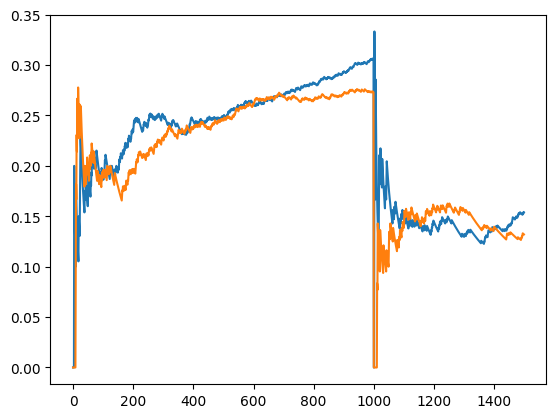

In [602]:
afficher(cumulative_rewards,aligned_ctr)

15000
1543
0.10286666666666666


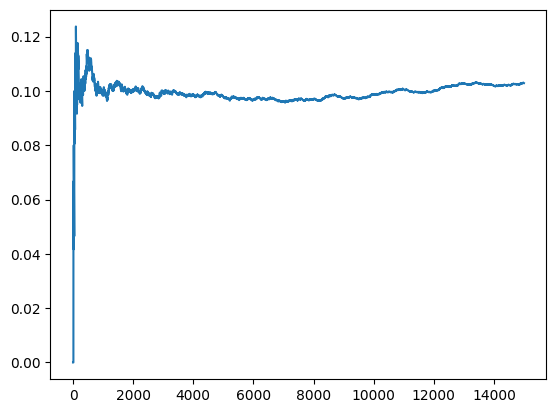

In [480]:
# METHODE 1
#Initialisation
linucb_policy_object = linucb_policy(K_arms = 10, d = df_encoded.shape[1]-1, alpha=1,version= -1)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded,linucb_policy_object,False)


print(linucb_policy_object.linucb_arms[0].A.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)


unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded.tail(15000),linucb_policy_object,True)

print(linucb_policy_object.linucb_arms[0].A.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)


(37, 1)
15000
4013
0.26753333333333335


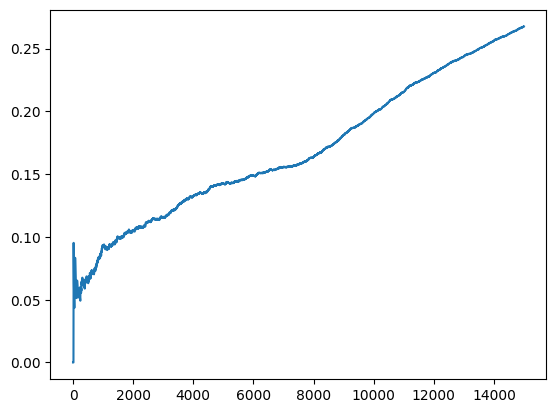

In [496]:
"""# METHODE 2
#Initialisation
linucb_policy_object = linucb_policy_bis(K_arms = 10, d = df_encoded.shape[1]-1, alpha=0.5,version= 1,compo_feature=dict_info_data)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object = ctr_simulator(df_encoded,linucb_policy_object,False)


print(linucb_policy_object.linucb_arms[0].A_theta.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object = ctr_simulator(df_encoded.tail(15000),linucb_policy_object,True)"""


print(linucb_policy_object.linucb_arms[0].A_theta.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)

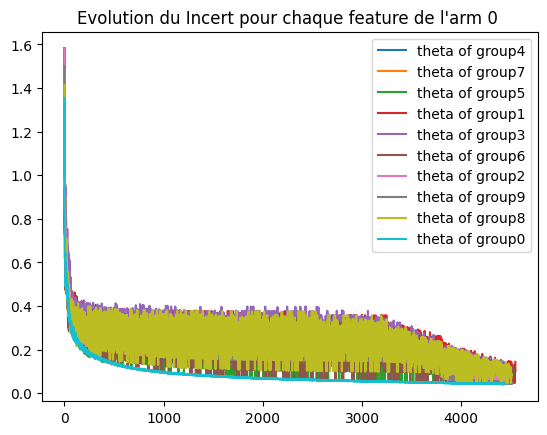

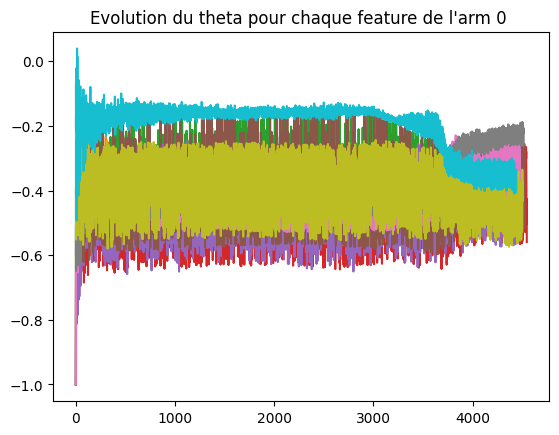

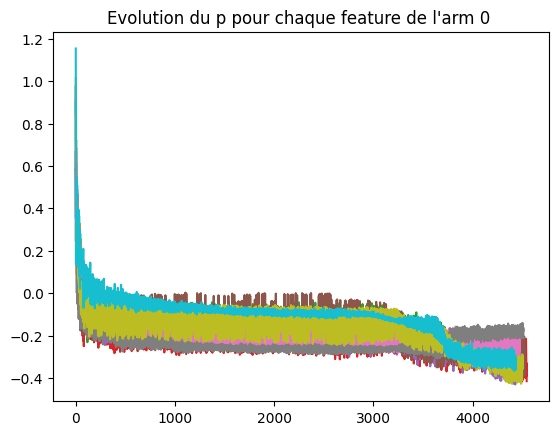

In [497]:
def initiate_ucb_ev_dict(listt):
    result = {}
    for i in listt :
        result[i]={'p':[],'theta':[],'Incert':[]}
    return result


def evolution_paramètre_arm(arm_id,listt):
    arm_ucb_ev=linucb_policy_object.linucb_arms[arm_id].ucb_evo
    result=initiate_ucb_ev_dict( listt)
    for e in arm_ucb_ev:
        feature = e[0]
        result[feature]['p'].append(float(e[1]))
        result[feature]['theta'].append(float(e[2]))
        result[feature]['Incert'].append(float(e[3]))
    return result

arm = 0
fromm = 0
to = -1
listt = list(df_encoded['cluster'].value_counts().index)
result=evolution_paramètre_arm(arm,listt)
for i in listt:
    plt.plot(result[i]['Incert'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du Incert pour chaque feature de l'arm 0 ")
plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['theta'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du theta pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['p'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du p pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

# form de la courbe => racine(1/x)=1/racine(x)
# le alpha doit faire en sorte que incercitude doit etre dans le meme ordre de grandeur que theta



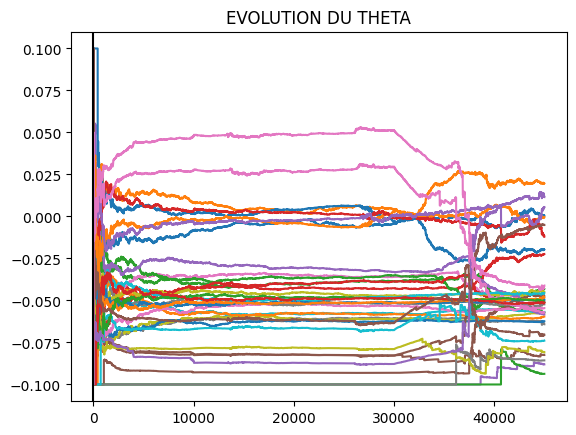

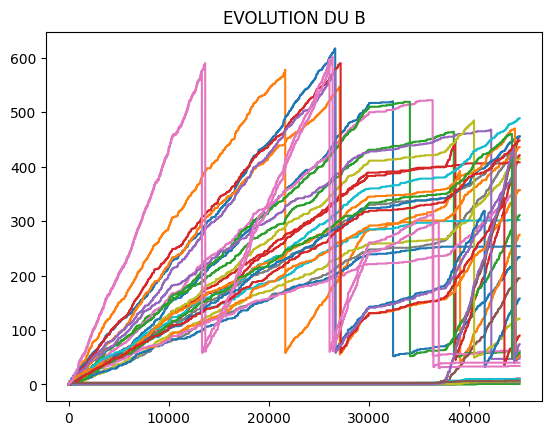

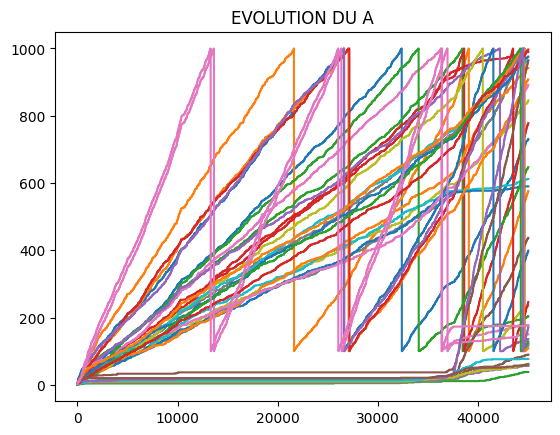

In [498]:
# Créer l'array de données
arm = 0
fromm = 0
to = -1
axe=0
dataT = np.array(linucb_policy_object.linucb_arms[arm].theta_list[fromm:to])
dataB = np.array(linucb_policy_object.linucb_arms[arm].b_list[fromm:to])
dataA = np.array(linucb_policy_object.linucb_arms[arm].A_theta_list[fromm:to])

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataT.shape[1]):
    plt.plot(dataT[:,i,:], label='feature {}'.format(i))

#plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU THETA")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataB.shape[1]):
    plt.plot(dataB[:,i,:], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU B")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataA.shape[1]):
    plt.plot(dataA[:,i,:], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU A")
plt.show()

#0 4 8 -> 3 7
